## **Table of Contents**
* Import tools/libraries
* Load data set
* Target visualization
* Text Cleaning
* Remove Stopward
* Stemming
* TF-IDF model
* Split data set
* Logistic regression Model
* NB model
* Stochastic Gradient Descent

### **All the necessary tools/libraries**
All the tools that help us to complete this task.

In [1]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import os
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch
from collections import defaultdict
from collections import Counter
import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/quora-insincere-questions-classification/sample_submission.csv
/kaggle/input/quora-insincere-questions-classification/embeddings.zip
/kaggle/input/quora-insincere-questions-classification/train.csv
/kaggle/input/quora-insincere-questions-classification/test.csv
/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv
/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


### **Load data set**
This data set contain 6 columns but for text classification we need just two columns namely 1st columns and last columns. The columns name for this data set is not clear, so to fixed it we change the columns name.

In [2]:
columns  = ["sentiment", "ids", "date", "flag", "user", "text"]
data = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", names = columns)
data.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


As we work on only two columns namely sentiment and text so we can separate thoes two columns.

In [3]:
data = data[['sentiment','text']]
data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### **Target visualization**
our target is sentiment, and we have to predict when it is positive or negative. So, as our data set contain 0 and 4 so we need to replace thoes value as negative and possitive, and later we will encode thoes values as 0 and 1.

<AxesSubplot:>

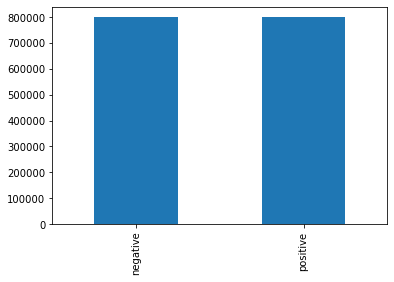

In [4]:
class_dict = {0:'negative', 4:'positive'}
data['sentiment'] = data['sentiment'].apply(lambda x:  class_dict[x])
count = data['sentiment'].value_counts()
count.plot(kind='bar')

### **Text Cleaning**
Our data set is not clear, it contains uppercase, brackets, links, punctuation and so many things. We need to remove thoes things from our data. Here, we will use re library to fixed thoes things.

In [5]:

def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [6]:
data['text'] = data['text'].apply(clean_text)
data.head()

,sentiment,text
0,negative,switchfoot awww thats a bummer you shoulda ...
1,negative,is upset that he cant update his facebook by t...
2,negative,kenichan i dived many times for the ball manag...
3,negative,my whole body feels itchy and like its on fire
4,negative,nationwideclass no its not behaving at all im ...


### **Remove Stopwords**
In Natural Language Processing (NLP), stop words are commonly occurring words that are filtered out before or after processing of text data. Stop words are usually words that do not contribute much to the meaning of a sentence or document, and are therefore not considered useful for text analysis. Examples of stop words include "the", "and", "a", "an", "in", "of", "is", "to", "that", "it", and so on.Removing stop words from a text can help reduce the dimensionality of the dataset, which can make analysis more efficient and effective.

In [7]:
stop_words = stopwords.words('english')

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
data['text'] = data['text'].apply(remove_stopwords)
data.head()

,sentiment,text
0,negative,switchfoot awww thats bummer shoulda got da...
1,negative,upset cant update facebook texting might cry r...
2,negative,kenichan dived many times ball managed save ...
3,negative,whole body feels itchy like fire
4,negative,nationwideclass behaving im mad cant see


### **Stemming**
Stemming is a technique used in natural language processing (NLP) to reduce words to their base or root form, which is called the stem. The goal of stemming is to reduce the inflectional and derivational forms of words to a common base form, which can simplify text analysis and improve the accuracy of text-based applications such as search engines, sentiment analysis, and text classification.

For example, the words "running", "runs", and "ran" can be reduced to their stem "run", which can help to identify them as variants of the same word and thus improve the accuracy of analysis.

In [8]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

data['text'] = data['text'].apply(stemm_text)
data.head()

,sentiment,text
0,negative,switchfoot awww that bummer shoulda got dav...
1,negative,upset cant updat facebook text might cri resul...
2,negative,kenichan dive mani time ball manag save rest...
3,negative,whole bodi feel itchi like fire
4,negative,nationwideclass behav im mad cant see


### **Target Encoding**

In [9]:
from sklearn.preprocessing import LabelEncoder

a = LabelEncoder()
a.fit(data['sentiment'])

data['sentiment'] = a.transform(data['sentiment'])
data.head()

,sentiment,text
0,0,switchfoot awww that bummer shoulda got dav...
1,0,upset cant updat facebook text might cri resul...
2,0,kenichan dive mani time ball manag save rest...
3,0,whole bodi feel itchi like fire
4,0,nationwideclass behav im mad cant see


### **Split data set**

In [10]:
from sklearn.model_selection import train_test_split
x = data['text']
y = data['sentiment']
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

### **TF-IDF Vectorizer**
TF-IDF stands for term frequency-inverse document frequency. It is a numerical statistic that is used to reflect how important a word is to a document in a collection or corpus of documents. It is a widely used model in information retrieval and text mining to measure the relevance of a word to a document.The main idea behind the TF-IDF model is to give more weight to words that appear frequently in a document but rarely in the corpus. This is done by computing two values:

Term Frequency (TF): The number of times a term appears in a document. A term that appears frequently in a document is likely to be important to the meaning of that document.

Inverse Document Frequency (IDF): The logarithmically scaled inverse fraction of the number of documents that contain the word. A term that appears in many documents is likely to be less important than a term that appears in only a few documents.


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectoriser = TfidfVectorizer(ngram_range=(1,2),max_features=3891472)
vectoriser.fit(x_train)

x_train = vectoriser.transform(x_train)
x_test  = vectoriser.transform(x_test)
#print('No. of feature_words: ', len(vectoriser.get_feature_names()))

### **Logistic Regression Model**
Logistic regression is a type of classification algorithm used in natural language processing (NLP) for text classification tasks. In text classification, the goal is to predict the category or label of a given text document

In [12]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(x_train, y_train)


y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Test accuracy: 0.7971
              precision    recall  f1-score   support

           0       0.80      0.79      0.80    199581
           1       0.80      0.80      0.80    200419

    accuracy                           0.80    400000
   macro avg       0.80      0.80      0.80    400000
weighted avg       0.80      0.80      0.80    400000



### **Confusion Matrix**
We use confusion metrics to see the performance of classification algorithm. Confusion matrics represent the value of true positive(tp), false positive(fp) ,true negative(tn) and false negative(fn).

<AxesSubplot:>

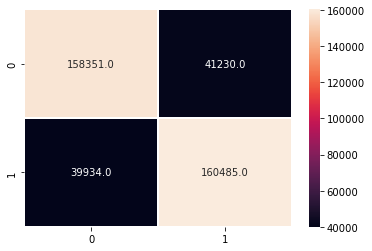

In [13]:
from sklearn.metrics import accuracy_score ,confusion_matrix, classification_report
confution_lg = confusion_matrix(y_test, y_pred) #confusion metrics
sns.heatmap(confution_lg, linewidths=0.01, annot=True,fmt= '.1f', color='red') #heat map

### **Prediction**

In [14]:
s = ['it is a bad question']
s = vectoriser.transform(s)
sentiment = model.predict(s)
sentiment

array([0])

### **Naive Bayes Model**

In [15]:
# Create a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# Train the model
nb.fit(x_train, y_train)
# Evaluate the model on the test set
y_p = nb.predict(x_test)
accuracy = accuracy_score(y_test, y_p)
print(f"Test accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_p))

Test accuracy: 0.7825
              precision    recall  f1-score   support

           0       0.76      0.82      0.79    199581
           1       0.81      0.74      0.77    200419

    accuracy                           0.78    400000
   macro avg       0.78      0.78      0.78    400000
weighted avg       0.78      0.78      0.78    400000



### **Stochastic Gradient Descent**

In [16]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier()
sgd.fit(x_train, y_train)
pred = sgd.predict(x_test)
print("test accuracy score of Stochastic Gradient Descent = ", accuracy_score(y_test, pred)*100)

test accuracy score of Stochastic Gradient Descent =  75.63775
